In [16]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
import warnings 

warnings.filterwarnings("ignore")

In [17]:
#Buscando os dados histórico do preço do ouro com a biblioteca yfinance.
ticker_simbol = "GC=F"
ticker = yf.Ticker(ticker_simbol)

In [18]:
#Dados de 5 anos
historical_data = ticker.history(period="5y")

In [19]:
df = pd.DataFrame(historical_data)
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-02-28 00:00:00-05:00,2877.100098,2877.100098,2834.100098,2836.800049,990,0.0,0.0
2025-03-03 00:00:00-05:00,2872.699951,2891.800049,2863.399902,2890.199951,423,0.0,0.0
2025-03-04 00:00:00-05:00,2886.100098,2927.899902,2886.100098,2909.600098,885,0.0,0.0
2025-03-05 00:00:00-05:00,2916.699951,2922.000000,2893.000000,2915.300049,885,0.0,0.0
2025-03-06 00:00:00-05:00,2929.500000,2935.899902,2897.600098,2924.000000,130655,0.0,0.0


In [20]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits'], dtype='object')

In [21]:
df = df.reset_index()

In [22]:
df = df[["Date", "Close"]]
df.head()

,Date,Close
0,2020-03-06 00:00:00-05:00,1670.800049
1,2020-03-09 00:00:00-04:00,1674.500000
2,2020-03-10 00:00:00-04:00,1659.099976
3,2020-03-11 00:00:00-04:00,1641.400024
4,2020-03-12 00:00:00-04:00,1589.300049


In [23]:
#Transformando a coluna data para o formato data hora
df["Date"] = pd.to_datetime(df["Date"], format="%Y-%m-%d")
df.head()

,Date,Close
0,2020-03-06 00:00:00-05:00,1670.800049
1,2020-03-09 00:00:00-04:00,1674.500000
2,2020-03-10 00:00:00-04:00,1659.099976
3,2020-03-11 00:00:00-04:00,1641.400024
4,2020-03-12 00:00:00-04:00,1589.300049


In [24]:
df.dtypes

Date     datetime64[ns, America/New_York]
Close                             float64
dtype: object

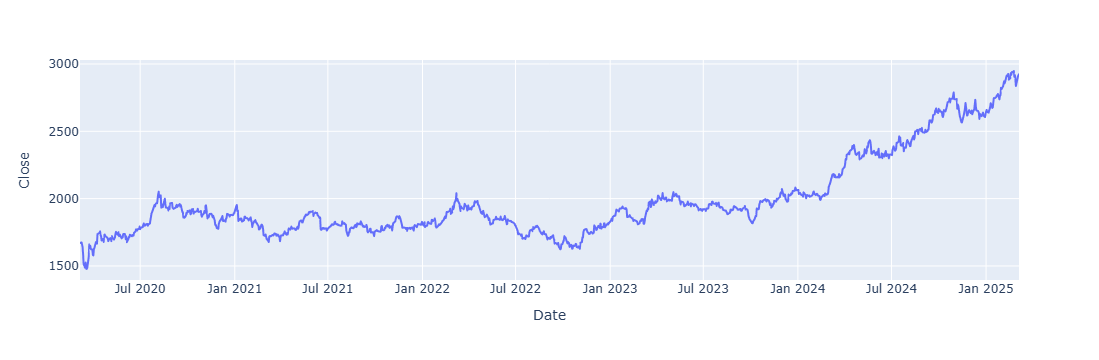

In [25]:
fig = px.line(df, x="Date", y="Close")
fig.show()

In [26]:
'''plt.figure(figsize=(10, 6))

sns.lineplot(data=treino, x="Date", y="Close", label="Treino", color="blue", linewidth=1.2)
sns.lineplot(data=teste, x="Date", y="Close", label="Teste", color="green", linewidth=1.2)

plt.title("Dados de Treino e Teste")
plt.xlabel("Data")
plt.ylabel("Preço Ouro")
plt.legend(title="Conjunto")
plt.grid(True)
plt.show()'''


'plt.figure(figsize=(10, 6))\n\nsns.lineplot(data=treino, x="Date", y="Close", label="Treino", color="blue", linewidth=1.2)\nsns.lineplot(data=teste, x="Date", y="Close", label="Teste", color="green", linewidth=1.2)\n\nplt.title("Dados de Treino e Teste")\nplt.xlabel("Data")\nplt.ylabel("Preço Ouro")\nplt.legend(title="Conjunto")\nplt.grid(True)\nplt.show()'

In [27]:
df.set_index('Date', inplace=True)

In [28]:
df.head()

,Close
Date,
2020-03-06 00:00:00-05:00,1670.800049
2020-03-09 00:00:00-04:00,1674.500000
2020-03-10 00:00:00-04:00,1659.099976
2020-03-11 00:00:00-04:00,1641.400024
2020-03-12 00:00:00-04:00,1589.300049


In [29]:
close_data = df['Close'].values.reshape(-1, 1)

In [30]:
close_data

array([[1670.80004883],
       [1674.5       ],
       [1659.09997559],
       ...,
       [2909.60009766],
       [2915.30004883],
       [2924.        ]])

In [31]:
#Escalonando os dados
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_data)

In [32]:
# função para preparar os dados de uma série temporal de forma que possam ser utilizados em modelos preditivos baseados em LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

In [33]:
# Definir comprimento da sequência
sequence_length = 30

In [34]:
# Criar sequências
X, y = create_sequences(scaled_data, sequence_length)

In [ ]:
# Separa os dados em 80% para treinar o modelo e 20% para testar o modelo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, 
                                                    random_state=42, shuffle=False)

## Arquitetura do Modelo LSTM

O modelo desenvolvido utiliza uma rede neural recorrente baseada em Long Short-Term Memory (LSTM) para a modelagem de séries temporais. A arquitetura é composta por quatro camadas principais, conforme descrito a seguir:

1. **Primeira camada LSTM:**  
   A primeira camada da rede consiste em 50 unidades LSTM, configuradas com `return_sequences=True`. Essa configuração permite que a camada retorne toda a sequência de estados ocultos para a próxima camada, preservando as informações temporais ao longo do processamento.  
   A entrada dessa camada é definida pelo parâmetro `input_shape=(X_train.shape[1], X_train.shape[2])`, onde:
   - `X_train.shape[1]` representa o número de passos temporais (*timesteps*).  
   - `X_train.shape[2]` representa a quantidade de variáveis explicativas (*features*) por *timestep*.  

2. **Segunda camada LSTM:**  
   A segunda camada também possui 50 unidades LSTM, mas com `return_sequences=False`, o que significa que apenas o último estado oculto será retornado. Essa configuração permite condensar as informações extraídas da sequência completa em um único vetor de características, adequado para as camadas densas subsequentes.  

3. **Camada densa intermediária:**  
   Após a extração de padrões temporais pelas camadas LSTM, o modelo conta com uma camada totalmente conectada (*dense*) contendo 25 neurônios. Essa camada tem a função de refinar a representação aprendida, capturando relações não lineares entre as características extraídas.  

4. **Camada de saída:**  
   A última camada do modelo é uma densa com um único neurônio (`Dense(1)`), cuja função é gerar a previsão final. Essa configuração é adequada para problemas de regressão, como previsão de séries temporais.  

A escolha dessa arquitetura visa capturar padrões complexos nas séries temporais, garantindo que a rede tenha capacidade de memória suficiente para modelar dependências de longo prazo, ao mesmo tempo em que mantém um número de parâmetros relativamente controlado para evitar sobreajuste.


In [38]:
# Construção da arquitutura do modelo 
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(50, return_sequences=True, 
                         input_shape=(X_train.shape[1], X_train.shape[2])),
    tf.keras.layers.LSTM(50, return_sequences=False),
    tf.keras.layers.Dense(25),
    tf.keras.layers.Dense(1)
])


In [39]:
# Compilar o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

In [40]:
# Treinar o modelo
model.fit(X_train, y_train, batch_size=30, epochs=20, validation_data=(X_test, y_test))

Epoch 1/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.0150 - val_loss: 0.0404
Epoch 2/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 0.0012 - val_loss: 0.0187
Epoch 3/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 8.1416e-04 - val_loss: 0.0025
Epoch 4/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 6.3672e-04 - val_loss: 0.0017
Epoch 5/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 6.7913e-04 - val_loss: 0.0010
Epoch 6/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 46ms/step - loss: 5.7240e-04 - val_loss: 9.5756e-04
Epoch 7/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 6.0806e-04 - val_loss: 9.3246e-04
Epoch 8/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 5.9187e-04 - val_loss: 8.7899e-04
Epoch 9/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 4.6004e-04 - val_loss: 8.6011e-04
Epoch 10/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - loss: 4.3155e-04 - val_loss: 7.9671e-04
Epoch 11/20
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 4.3842e-04 - val_loss: 7.7172e-04
Ep

In [43]:
# Fazer previsões
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverter a normalização

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step


In [44]:
 #Reverter a normalização do conjunto de teste
y_test = scaler.inverse_transform(y_test)

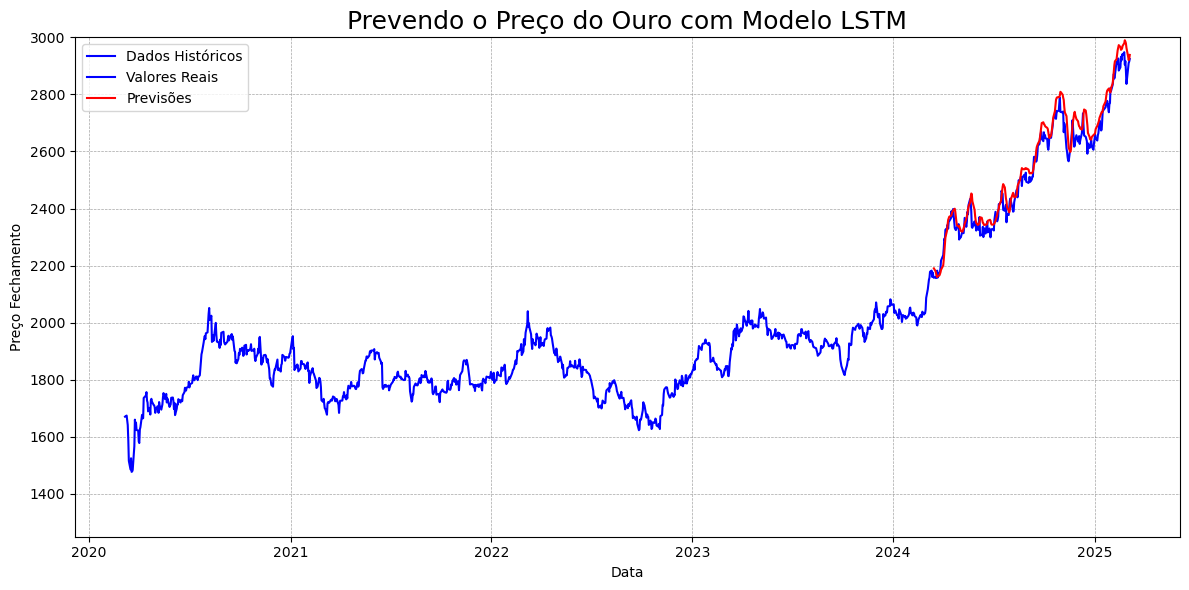

In [45]:
# Gráfico dos resultados
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], color='blue', label='Dados Históricos')
plt.plot(df.index[-len(y_test):], y_test, color='blue', label='Valores Reais')
plt.plot(df.index[-len(predictions):], predictions, color='red', label='Previsões')
plt.title('Prevendo o Preço do Ouro com Modelo LSTM', fontsize=18)
plt.xlabel('Data')
plt.ylabel('Preço Fechamento')
plt.ylim([1250,3000])
plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(loc='upper left', fontsize=10, frameon=True, shadow=True, fancybox=True)
plt.tight_layout()
plt.legend()
plt.show()